<a href="https://colab.research.google.com/github/VA0211/DAT301m_Group9/blob/main/mammonet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'vinmammoresize:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4523013%2F7738807%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240302%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240302T023137Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D84441c763147d7706e5039924f5971745cc9fab04339dc50db94161ff135ef968fdb582cf32eb88d127cd9ccf5f4c70f505fef5d7b730fd685b72a7444b8c614db49ecd0286ea9571ac63213faf5bbae9329d97fefaa118c4151e270d2267c68310b3808d6fa2315f1cda3ee7175ef1a9a0f95f525939402577526520fc7be7520c37d84be85a9ea5403068ffcf35db9f5b310f267c5bc5c37818e26ba9ea4a85e1560fa3a045fe2ad7cbc884deaa5b8307780f0cbdef56e6ffd5e10a428b404af018aadf486a997eb5636f5b5cc3d68a5f9f79874ca1d0127c309922409799cb865b14173b8caaa48109bd70871a1b7a0e7bc17c950ae216e8ff13e0e4c5b1b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1862401597 bytes downloaded
Downloaded and uncompressed: vinmammoresize
Data source import complete.


In [10]:
!pip install torchsampler pytorch_lightning torchmetrics

In [11]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from argparse import ArgumentParser
from sklearn.utils import shuffle
from skimage.io import imread

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as T
from torchvision import models

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

from torchsampler import ImbalancedDatasetSampler
from torchmetrics.functional import auroc

In [30]:
data_dir = '/kaggle/input/vinmammoresize/resize_all_512/kaggle/working'

image_size = (512, 512)     # image input size (depends on data pre-processing)
val_percent = 0.1           # how much of total training samples are used for model selection (default 10%)
batch_size = 8            # batch size may need to be adjusted depending on GPU memory
epochs = 2                 # number of training epochs
num_workers = 1            # number threads for data processing


class MammoDataset(Dataset):
    def __init__(self, data, data_dir, image_size, augmentation=False):
        self.data = data.reset_index(drop=True)
        self.data_dir = data_dir
        self.image_size = image_size
        self.do_augment = augmentation

        # photometric data augmentation
        self.photometric_augment = T.Compose([
            T.RandomApply(transforms=[T.ColorJitter(brightness=0.2, contrast=0.2)], p=0.5),
        ])

        # geometric data augmentation
        self.geometric_augment = T.Compose([
            T.RandomApply(transforms=[T.RandomAffine(degrees=10, scale=(0.9, 1.1))], p=0.5),
        ])

        self.samples = []
        for idx, _ in enumerate(tqdm(range(len(self.data)), desc='Loading Data')):
            img_path = os.path.join(self.data_dir, self.data.loc[idx, 'study_id'], self.data.loc[idx, 'image_id'] + '.png')
            img_label = np.array(self.data.loc[idx, 'malignancy_label'], dtype='int64')

            sample = {'image_path': img_path, 'label': img_label, 'study_id': self.data.loc[idx, 'study_id'], 'image_id': self.data.loc[idx, 'image_id']}
            self.samples.append(sample)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        sample = self.get_sample(item)

        image = torch.from_numpy(sample['image']).unsqueeze(0)
        label = torch.from_numpy(sample['label'])

        image = image.repeat(3, 1, 1)

        if self.do_augment:
            image = self.photometric_augment(image.type(torch.ByteTensor)).type(torch.FloatTensor)
            image = self.geometric_augment(image)

        return {'image': image, 'label': label, 'study_id': sample['study_id'], 'image_id': sample['image_id']}

    def get_sample(self, item):
        sample = self.samples[item]
        image = imread(sample['image_path']).astype(np.float32)

        return {'image': image, 'label': sample['label'], 'study_id': sample['study_id'], 'image_id': sample['image_id']}

    def get_labels(self):
        labels = [int(sample['label']) for sample in self.samples]
        return labels


class MammoDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, image_size, val_percent, batch_size, num_workers):
        super().__init__()
        self.data_dir = data_dir
        self.image_size = image_size
        self.val_percent = val_percent
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.data = pd.read_csv('/kaggle/input/vinmammoresize/breast-level_annotations.csv')
        self.data['malignancy_label'] = self.data['breast_birads']

        # Define positive and negatives based on BI-RADS categories
        self.data.loc[self.data['malignancy_label'] == 'BI-RADS 1', 'malignancy_label'] = 0
        self.data.loc[self.data['malignancy_label'] == 'BI-RADS 2', 'malignancy_label'] = 0
        self.data.loc[self.data['malignancy_label'] == 'BI-RADS 3', 'malignancy_label'] = 1
        self.data.loc[self.data['malignancy_label'] == 'BI-RADS 4', 'malignancy_label'] = 1
        self.data.loc[self.data['malignancy_label'] == 'BI-RADS 5', 'malignancy_label'] = 1

        # Use pre-defined splits to separate data into development and testing
        self.dev_data = self.data[self.data['split'] == 'training']
        self.test_data = self.data[self.data['split'] == 'test']

        # Split development data into training and validation (for model selection)
        # Making sure images from the same subject are within the same set
        unique_study_ids = self.dev_data.study_id.unique()

        unique_study_ids = shuffle(unique_study_ids)
        num_train = (round(len(unique_study_ids)*(1.0 - self.val_percent)))

        valid_sub_id = unique_study_ids[num_train:]
        self.dev_data.loc[self.dev_data.study_id.isin(valid_sub_id), "split"]="validation"

        self.train_data = self.dev_data[self.dev_data['split'] == 'training']
        self.val_data = self.dev_data[self.dev_data['split'] == 'validation']

        self.train_set = MammoDataset(self.train_data, data_dir, self.image_size, augmentation=True)
        self.val_set = MammoDataset(self.val_data, data_dir, self.image_size, augmentation=False)
        self.test_set = MammoDataset(self.test_data, data_dir, self.image_size, augmentation=False)

        train_labels = self.train_set.get_labels()
        train_class_count = np.array([len(np.where(train_labels == t)[0]) for t in np.unique(train_labels)])

        val_labels = self.val_set.get_labels()
        val_class_count = np.array([len(np.where(val_labels == t)[0]) for t in np.unique(val_labels)])

        test_labels = self.test_set.get_labels()
        test_class_count = np.array([len(np.where(test_labels == t)[0]) for t in np.unique(test_labels)])

        print('samples (train): ',len(self.train_set))
        print('samples (val):   ',len(self.val_set))
        print('samples (test):  ',len(self.test_set))
        print('pos/neg (train): {}/{}'.format(train_class_count[1], train_class_count[0]))
        print('pos/neg (val):   {}/{}'.format(val_class_count[1], val_class_count[0]))
        print('pos/neg (test):  {}/{}'.format(test_class_count[1], test_class_count[0]))
        print('pos (train):     {:0.2f}%'.format(train_class_count[1]/len(train_labels)*100.0))
        print('pos (val):       {:0.2f}%'.format(val_class_count[1]/len(val_labels)*100.0))
        print('pos (test):      {:0.2f}%'.format(test_class_count[1]/len(test_labels)*100.0))

    def train_dataloader(self):
        return DataLoader(dataset=self.train_set, batch_size=self.batch_size, sampler=ImbalancedDatasetSampler(self.train_set), num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(dataset=self.val_set, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(dataset=self.test_set, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)


class MammoNet(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.num_classes = 2
        self.predictions = []
        self.targets = []
        self.study_ids = []
        self.image_ids = []

        self.train_step_preds = []
        self.train_step_trgts = []
        self.val_step_preds = []
        self.val_step_trgts = []

        # Default model is an ImageNet pre-trained ResNet-18
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        # self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, self.num_classes)

    def forward(self, x):
        return self.model.forward(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def process_batch(self, batch):
        img, lab = batch['image'], batch['label']
        out = self.forward(img)
        prd = torch.softmax(out, dim=1)
        loss = F.cross_entropy(out, lab)
        return loss, prd, lab

    def training_step(self, batch, batch_idx):
        loss, prd, lab = self.process_batch(batch)
        self.train_step_preds.append(prd)
        self.train_step_trgts.append(lab)
        self.log('train_loss', loss, batch_size=batch_size)
         # Print labels for the first batch in each epoch
        # if batch_idx == 0:
        #     print(f"Labels in the first training batch of epoch {self.current_epoch}: {lab}")
        #     print(lab.cpu().numpy())
        #     print(np.where(lab.cpu().numpy() == 0)[0])
        #     print(np.where(lab.cpu().numpy() == 1)[0])
        #     print(len(np.where(lab.cpu().numpy() == 1)[0]))
        #     print(len(np.where(lab.cpu().numpy() == 0)[0]))

        count_positive = len(np.where(lab.cpu().numpy() == 1)[0])
        count_negative = len(np.where(lab.cpu().numpy() == 0)[0])

        if count_negative != 0:
            batch_ratio = count_positive / count_negative
        else:
            batch_ratio = 0.0  # or any other value that makes sense in your context
        # batch_ratio = len(np.where(lab.cpu().numpy() == 1)[0]) / len(np.where(lab.cpu().numpy() == 0)[0])
        self.log('batch_ratio', batch_ratio, batch_size=batch_size)
        grid = torchvision.utils.make_grid(batch['image'][0:4, ...], nrow=2, normalize=True)
        self.logger.experiment.add_image('images', grid, self.global_step)
        return loss

    def on_train_epoch_end(self):
        all_preds = torch.cat(self.train_step_preds, dim=0)
        all_trgts = torch.cat(self.train_step_trgts, dim=0)
        auc = auroc(all_preds, all_trgts, num_classes=self.num_classes, average='macro', task='multiclass')
        self.log('train_auc', auc, batch_size=len(all_preds))
        self.train_step_preds.clear()
        self.train_step_trgts.clear()

    def validation_step(self, batch, batch_idx):
        loss, prd, lab = self.process_batch(batch)
        self.val_step_preds.append(prd)
        self.val_step_trgts.append(lab)
        self.log('val_loss', loss, batch_size=batch_size)

    def on_validation_epoch_end(self):
        all_preds = torch.cat(self.val_step_preds, dim=0)
        all_trgts = torch.cat(self.val_step_trgts, dim=0)
        auc = auroc(all_preds, all_trgts, num_classes=self.num_classes, average='macro', task='multiclass')
        self.log('val_auc', auc, batch_size=len(all_preds))
        self.val_step_preds.clear()
        self.val_step_trgts.clear()

    def on_test_start(self):
        self.predictions = []
        self.targets = []
        self.study_ids = []
        self.image_ids = []

    def test_step(self, batch, batch_idx):
        _, prd, lab = self.process_batch(batch)
        self.predictions.append(prd)
        self.targets.append(lab.squeeze())
        self.study_ids.append(batch['study_id'])
        self.image_ids.append(batch['image_id'])


def save_predictions(model, output_fname):
    prds = torch.cat(model.predictions, dim=0)
    trgs = torch.cat(model.targets, dim=0)
    std_ids = [id for sublist in model.study_ids for id in sublist]
    img_ids = [id for sublist in model.image_ids for id in sublist]

    auc = auroc(prds, trgs, num_classes=2, average='macro', task='multiclass')

    print('AUROC (test)')
    print(auc)

    cols_names = ['class_' + str(i) for i in range(0, 2)]

    df = pd.DataFrame(data=prds.cpu().numpy(), columns=cols_names)
    df['target'] = trgs.cpu().numpy()
    df['study_id'] = std_ids
    df['image_id'] = img_ids
    df.to_csv(output_fname, index=False)

In [31]:
def main():

    # sets seeds for numpy, torch, python.random and PYTHONHASHSEED.
    pl.seed_everything(42, workers=True)

    # data
    data = MammoDataModule(data_dir=data_dir,
                              image_size=image_size,
                              val_percent=val_percent,
                              batch_size=batch_size,
                              num_workers=num_workers)

    # model
    model = MammoNet()

    # Create output directory
    output_base_dir = '/kaggle/working/'
    output_name = 'resnet18'
    output_dir = os.path.join(output_base_dir,output_name)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print('=============================================================')
    print('Training...')

    # train
    checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode='min')
    trainer = pl.Trainer(
        callbacks=[checkpoint_callback],
        log_every_n_steps=5,
        max_epochs=epochs,
#         accelerator=hparams.dev,
        devices=1,
        logger=TensorBoardLogger(output_base_dir, name=output_name),
    )
    trainer.logger._default_hp_metric = False
    trainer.fit(model, data)

    model = MammoNet.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    print('=============================================================')
    print('Testing...')

    trainer.test(model=model, datamodule=data)
    save_predictions(model=model, output_fname=os.path.join(output_dir, 'predictions.csv'))

In [32]:
main()

INFO:lightning_fabric.utilities.seed:Seed set to 42

Loading Data: 100%|██████████| 14400/14400 [00:00<00:00, 21061.16it/s]

Loading Data: 100%|██████████| 1600/1600 [00:00<00:00, 23639.04it/s]

Loading Data: 100%|██████████| 4000/4000 [00:00<00:00, 24283.98it/s]


samples (train):  14400
samples (val):    1600
samples (test):   4000
pos/neg (train): 1340/13060
pos/neg (val):   194/1406
pos/neg (test):  384/3616
pos (train):     9.31%
pos (val):       12.12%
pos (test):      9.60%


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.2 M
---------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


Training...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing...


Testing: |          | 0/? [00:00<?, ?it/s]

AUROC (test)
tensor(0.6429, device='cuda:0')


In [33]:
!zip -r file.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/resnet18/ (stored 0%)
  adding: kaggle/working/resnet18/version_3/ (stored 0%)
  adding: kaggle/working/resnet18/version_3/events.out.tfevents.1709350310.e6a07bbe3cc4.357.3 (deflated 0%)
  adding: kaggle/working/resnet18/version_3/hparams.yaml (stored 0%)
  adding: kaggle/working/resnet18/version_0/ (stored 0%)
  adding: kaggle/working/resnet18/version_0/events.out.tfevents.1709347117.e6a07bbe3cc4.357.0 (deflated 0%)
  adding: kaggle/working/resnet18/version_0/hparams.yaml (stored 0%)
  adding: kaggle/working/resnet18/version_2/ (stored 0%)
  adding: kaggle/working/resnet18/version_2/events.out.tfevents.1709348200.e6a07bbe3cc4.357.2 (deflated 9%)
  adding: kaggle/working/resnet18/version_2/hparams.yaml (stored 0%)
  adding: kaggle/working/resnet18/version_1/ (stored 0%)
  adding: kaggle/working/resnet18/version_1/events.out.tfevents.1709347755.e6a07bbe3cc4.357.1 (deflated 0%)
  adding: kaggle/working/resnet18/version_1/hpar

In [34]:
from IPython.display import FileLink
FileLink(r'file.zip')

/content/file.zip

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [36]:
result_dir = '/kaggle/working/resnet18/'
data = pd.read_csv(result_dir + 'predictions.csv')

preds = np.stack([data['class_0'],data['class_1']]).transpose()
targets = np.array(data['target'])
fpr, tpr, _ = roc_curve(targets, preds[:,1])
roc_auc = auc(fpr, tpr)

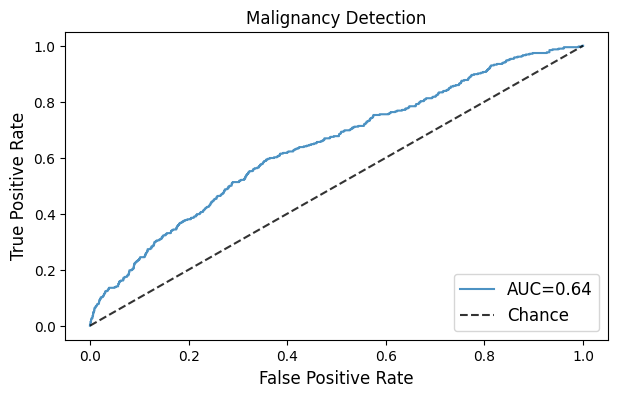

In [37]:
fig, ax = plt.subplots(figsize=(7,4))
plt.plot(fpr, tpr, lw=1.5, alpha=.8, label='AUC=%0.2f' % roc_auc)
ax.plot([0, 1], [0, 1], linestyle='--', lw=1.5, color='k', label='Chance', alpha=.8)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc="lower right", fontsize=12)
plt.title('Malignancy Detection', fontsize=12)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
plt.show()